In [21]:
import django
import sys, os
import datetime
import random
import matplotlib.pyplot as plt

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

import pandas as pd
import numpy as np


from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, cohen_kappa_score, f1_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack
import datetime

from learning_utils import utils

In [2]:
q = Query.objects.get(pk=1457)

In [3]:
columns = [
    'id',
    'UT_id',
    'authors',
    'content',
    'first_author',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

In [4]:
df = pd.read_csv('docs.csv').sample(frac=1).reset_index(drop=True)
df['date'] = df['rated'].apply(lambda x: datetime.datetime.strptime(x[:19],"%Y-%m-%d %H:%M:%S"))
df = df[df['date'] > datetime.datetime(2018,6,1,0,0,0)].reset_index(drop=True)
print(df.shape)
y = df['relevant']
df.head()

(1984, 13)


,Unnamed: 0,UT_id,authors,content,first_author,id,rated,relevant,tag,title,wosarticle__de,wosarticle__wc,date
0,1464,WOS:000301121500009,"Caamano, D, Goodwin, P, Buffington, JM",Detailed field measurements and simulations of...,"Caamano, D",497042,2018-09-24 04:10:11.765770+00:00,0,760,Flow structure through pool-riffle sequences a...,Gravel-bed rivers; pools; riffles; 3-d models;...,['Environmental Sciences; Water Resources'],2018-09-24 04:10:11
1,1542,WOS:000392480200048,"Rathnayaka, K, Malano, H, Arora, M",A comprehensive evaluation framework that can ...,"Rathnayaka, K",5411,2018-09-21 12:03:08.962284+00:00,1,760,Assessment of Sustainability of Urban Water Su...,sustainability; evaluation criteria; urban wat...,['Water Resources'],2018-09-21 12:03:08
2,87,WOS:000232314100022,"Osmanov, S","Research teams from five countries, Brazil, Ch...","Osmanov, S",461532,2018-09-20 12:13:13.040085+00:00,0,760,Cost effectiveness and delivery study for futu...,access; AIDS; capacity; cost effectiveness; de...,['Immunology; Infectious Diseases; Virology'],2018-09-20 12:13:13
3,296,WOS:A1997YG23200003,NaN,"The original paper by H.M. Steven, with this t...",NaN,701766,2018-09-21 09:19:33.491601+00:00,1,760,The silviculture of conifers in Great Britain,NaN,['Forestry'],2018-09-21 09:19:33
4,2375,WOS:000223459200001,"Boardman, AG, Woodruff, AL",This study explored the impact of learning a n...,"Boardman, AG",470602,2018-09-20 08:46:14.212278+00:00,0,753,"Teacher change and ""high-stakes"" assessment: w...",NaN,['Education & Educational Research'],2018-09-20 08:46:14


In [5]:
uncoded_docs = Doc.objects.filter(query=q,content__iregex='\w').exclude(docownership__relevant__gt=0)
uncoded_docs_nosus = Doc.objects.filter(
    query=q,content__iregex='\w'
).exclude(
    docownership__relevant__gt=0
).exclude(
    wosarticle__so__icontains="sustainab"
)

wos_sus = Doc.objects.filter(
    query=q,
    wosarticle__kwp__icontains="sustainab"
).exclude(
    title__icontains="sustainab"
).exclude(
    content__icontains="sustainab"
).exclude(
    wosarticle__de="sustainab"
).values_list('pk',flat=True)

t753 = Doc.objects.filter(tag__id=753).values_list('pk',flat=True)

uncoded_docs_nosus = uncoded_docs_nosus.exclude(id__in=list(wos_sus)+list(t753))



In [6]:
s_ids = random.sample(list(uncoded_docs_nosus.values_list('pk',flat=True)),5000)
new_docs = Doc.objects.filter(id__in=s_ids)

unseen = list(new_docs.values(*columns))
new_df = pd.DataFrame.from_dict(unseen)

In [7]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=15, max_df=0.6, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)

ab_X = vec.fit_transform(list(df['content']) + list(new_df['content']))

In [8]:
ab_X

len(df.index)

X_train = ab_X[list(range(len(df.index)))]
y_train = list(df['relevant'])

X_pred = ab_X[len(df.index):]

print(ab_X.shape)
print(X_train.shape)
print(X_pred.shape)

(6984, 6263)
(1984, 6263)
(5000, 6263)


In [9]:
y_train

[0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,


In [15]:
clf = MultinomialNB(alpha=0.1)     
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_pred)

new_df['prediction'] = y_pred[:,1]

In [17]:
new_df.sort_values('prediction').head()

,UT_id,authors,content,first_author,id,title,wosarticle__de,wosarticle__wc,prediction
1586,WOS:000264288000001,"Gine-Garriga, M, Martin, C, Puig-Ribera, A, An...",Background: Declining physical activity is ass...,"Gine-Garriga, M",658563,Referral from primary care to a physical activ...,None,"[Public, Environmental & Occupational Health]",0.000206
2943,WOS:000367027000008,"Ditta, LC, Ditta, LC, Ditta, LC, Pereiras, LA,...",PURPOSE To report our experince in establishin...,"Ditta, LC",84077,Establishing a surgical outreach program in th...,None,[Ophthalmology; Pediatrics],0.000317
3809,WOS:000263229000025,"Peikes, D, Chen, A, Schore, J, Brown, R",Context Medicare expenditures of patients with...,"Peikes, D",451003,Effects of Care Coordination on Hospitalizatio...,None,"[Medicine, General & Internal]",0.000388
4649,WOS:000354426400001,"Ober, AJ, Watkins, KE, Hunter, SB, Lamp, K, Li...",Background: Millions of people who need treatm...,"Ober, AJ",135222,An organizational readiness intervention and r...,Implementation; Organizational readiness; Evid...,[Health Care Sciences & Services; Health Polic...,0.000576
2890,WOS:000270890400012,"Rennert, W, Koop, E",Background and Objectives: We present a model ...,"Rennert, W",314010,Primary Health Care for Remote Village Communi...,None,"[Primary Health Care; Medicine, General & Inte...",0.000962


In [18]:
for i, row in new_df.sort_values('prediction',ascending=False).head(5).iterrows():
    print(row['title'])
    print("predicted: {:.2}".format(row['prediction']))
    print(row['content'])

An integrative modeling framework to evaluate the productivity and sustainability of biofuel crop production systems
predicted: 1.0
The potential expansion of biofuel production raises food, energy, and environmental challenges that require careful assessment of the impact of biofuel production on greenhouse gas (GHG) emissions, soil erosion, nutrient loading, and water quality. In this study, we describe a spatially explicit integrative modeling framework (SEIMF) to understand and quantify the environmental impacts of different biomass cropping systems. This SEIMF consists of three major components: (1) a geographic information system (GIS)-based data analysis system to define spatial modeling units with resolution of 56 m to address spatial variability, (2) the biophysical and biogeochemical model Environmental Policy Integrated Climate (EPIC) applied in a spatially-explicit way to predict biomass yield, GHG emissions, and other environmental impacts of different biofuel crops produc

In [19]:
for i, row in new_df.sort_values('prediction').head(5).iterrows():
    print(row['title'])
    print("predicted: {:.2}".format(row['prediction']))
    print(row['content'])

Referral from primary care to a physical activity programme: establishing long-term adherence? A randomized controlled trial. Rationale and study design
predicted: 0.00021
Background: Declining physical activity is associated with a rising burden of global disease. There is little evidence about effective ways to increase adherence to physical activity. Therefore, interventions are needed that produce sustained increases in adherence to physical activity and are cost-effective. The purpose is to assess the effectiveness of a primary care physical activity intervention in increasing adherence to physical activity in the general population seen in primary care. Method and design: Randomized controlled trial with systematic random sampling. A total of 424 subjects of both sexes will participate; all will be over the age of 18 with a low level of physical activity (according to the International Physical Activity Questionnaire, IPAQ), self-employed and from 9 Primary Healthcare Centres (PH

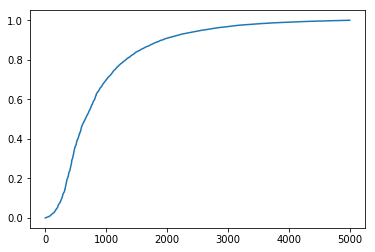

In [22]:
pdf = new_df.sort_values('prediction').reset_index(drop=True)
plt.plot(pdf.index,pdf['prediction'])

In [26]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
tag = Tag(
    title="predicted irrelevant sample {}".format(now),
    query=q
)
tag.save()
uc = q.users.count()
for i, row in new_df.sort_values('prediction').head(500).iterrows():
    d = Doc.objects.get(UT__UT=row['UT_id'])
    u = q.users.all()[i % uc]
    do = DocOwnership(
        doc=d,
        user=u,
        query=q,
        tag=tag
    )
    do.save()

Referral from primary care to a physical activity programme: establishing long-term adherence? A randomized controlled trial. Rationale and study design
Establishing a surgical outreach program in the developing world: pediatric strabismus surgery in Guatemala City, Guatemala
Effects of Care Coordination on Hospitalization, Quality of Care, and Health Care Expenditures Among Medicare Beneficiaries 15 Randomized Trials
An organizational readiness intervention and randomized controlled trial to test strategies for implementing substance use disorder treatment into primary care: SUMMIT study protocol
Primary Health Care for Remote Village Communities in Honduras: A Model for Training and Support of Community Health Workers
Priorities for antiretroviral therapy research in sub-Saharan Africa - A 2002 consensus conference in Zambia
One year follow-up of patients with screen-detected metabolic syndrome in primary care: an observational study
Mental Health Screening Among Newly Arrived Refuge

In [29]:
new_df.to_csv('predicted_docs.csv')